### The Adam algorithm for bivariate function.

In [24]:
import numpy as np
import polars as pl
from sklearn.preprocessing import MinMaxScaler

#Read the dataset, from which we take the features.
dataset = pl.read_csv("WineQuality.csv", separator=';', ignore_errors = True)


#Select the features for the model.
target_var = "quality"
predictor = "pH"


class Adam():
        
    #Note, we assume obj_func takes two, equally-shaped, one-dimensional arrays and two parameters: b0 and b1 (thus n_params = 2)
    def __init__(self,  params:np.ndarray,  X: np.ndarray, y: np.ndarray, alpha:float = 0.001, eps: float = 10**(-8)):
        assert X.shape[0] == y.shape[0], "The first dimensions of the arrays should match!"

        assert type(alpha) is float and alpha > 0, "The alpha parameter needs to be a positive, numerical value."

    
        self.params = params
        self.n_params = params.shape[0]
        
        #Declare the X variable and y variable.
        self.X = X
        self.y = y

        #Define the alpha and eps which stands for: learning-rate and zero-division-preventer respectively.
        self.alpha = alpha
        self.eps = eps

        #Declare the initial state of m and v (first-moment gradient, second-moment gradient).
        self.m = np.zeros(self.n_params)
        self.v = np.zeros(self.n_params)

    def MSE(self, b0: float, b1:float, x1:np.ndarray, y1:np.ndarray) -> float:
        return np.sum((b1*x1 + b0 - y1)**2)/x1.shape[0]


    def MSEBatch(self, b0:float, b1:float,batch_size: int, k:int) ->float:
        """The function computes the value of the loss function k-times, every time taking batch_sizes samples to compute the loss"""
        assert batch_size <= self.X.shape[0], "The size of batch cannot be greater than the overall number of observation"


        losses_values = np.zeros(shape =k, dtype = np.float64)

        for i in range(k):
            sample = np.random.choice(self.X.shape[0], batch_size, 
                                      replace = False)
            
            
            #Find the loss value for the sample, Afterwards, store in in the array
            loss = self.MSE(b0, b1, self.X[sample], self.y[sample])
            losses_values[i] = loss

        return np.mean(losses_values)





    def FindGradients(self,h:float) -> np.ndarray:
        partial_derivs = np.zeros(self.n_params)


        #Computing the gradient with respect to the whole dataset.
        substractor = self.MSE(self.params[0], self.params[1], self.X, self.y)    
        partial_derivs[0] = (self.MSE(self.params[0]+h, self.params[1], self.X, self.y) - substractor)/h
        partial_derivs[1] = (self.MSE(self.params[0], self.params[1]+h, self.X, self.y) - substractor)/h

        # #Finding the gradient with respect to some fraction of the whole dataset.
        # substractor = self.MSE(self.params[0], self.params[1], self.X, self.Y)    
        # partial_derivs[0] = (self.MSE(self.params[0]+h, self.params[1], self.X) - substractor)/h
        # partial_derivs[1] = (self.MSE(self.params[0], self.params[1]+h, self.Y) - substractor)/h




        return partial_derivs


    
    def UpdateMoments(self, bet1:float, bet2:float, h:float):
        Gradients = self.FindGradients(h)

        new_m = (bet1*self.m + (1-bet1)*Gradients)/(1-bet1)
        new_v = (bet2*self.v + (1-bet2)*Gradients**2)/(1-bet2)


        return new_m, new_v
    
    def UpdateParameters(self, bet1:float, bet2:float, h:float):
        m_corr, v_corr = self.UpdateMoments(bet1, bet2, h)

        self.params = self.params - self.alpha * m_corr / ( np.sqrt(v_corr) +self.eps)

        return self.params
    
    



def FitTheLineV2(dataset:pl.DataFrame, predictor:str, target_var:str, eps = 0.001) -> tuple[np.ndarray, float]:
    """The function finds the optimal parameters, b0, b1, so that 
    the loss function of linear regressionmodel dataset[target_var] = b0 + b1*dataset[predictor] is minimized"""

    np.random.seed(1)
    B = np.random.uniform(low = -3, high = 3, size = 2)

    #Take the X feature and y feature from the dataset. Then, numpyize it!. Afterward, normalize it!
    MinMaxScaler_X = MinMaxScaler()
    MinMaxScaler_y = MinMaxScaler()

    X = MinMaxScaler_X.fit_transform(dataset.select(predictor).to_numpy())
    y = MinMaxScaler_y.fit_transform(dataset.select(target_var).to_numpy())


    #Declare an instance of the Adam optimizer.
    Adamek = Adam(B, X, y)

    #The following variable indicates the difference between the new value of the function and the old one.
    #If it's  absolute is less than eps, break the loop.
    val_change= float('inf')

    for _ in range(2500):
        B_new = Adamek.UpdateParameters(0.9, 0.9, 0.001)

        B = B_new



    return B

        

#FitTheLineV2(dataset, predictor, target_var, eps = 0.0005)
X = dataset.select(predictor).to_numpy()
Y = dataset.select(target_var).to_numpy()




2.4711918
2.445352157598499


### Comparison of the values of the losses function generated by AdamBatch and "classic" Adam.

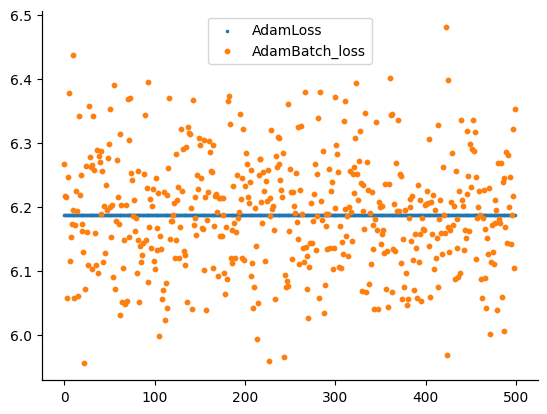

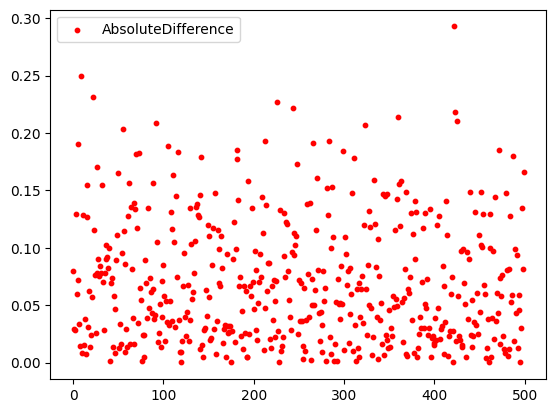

In [48]:
import matplotlib.pyplot as plt


def GenerateComparisonArray(n_iterations:int, batch_size:int, k_batches:int):
    Adamek = Adam(np.array([0,0]), X, Y)
    Comparison_array = np.zeros(shape = [n_iterations, 4])

    for i in range(n_iterations):
        Adam_loss = Adamek.MSE(-2, 3, X, Y)
        AdamBatch_loss = Adamek.MSEBatch(-2, 3, batch_size, k_batches)

        
        Comparison_array[i, 0] = Adam_loss
        Comparison_array[i, 1] = AdamBatch_loss
        Comparison_array[i, 2] = i
        Comparison_array[i,3] = abs(Adam_loss-AdamBatch_loss)


    return Comparison_array



def VisualizeTheResults(n_iterations:int, batch_size:int, k_batches:int):
    ComparisonFig = plt.figure(num="Comparison")
    osie_set = ComparisonFig.add_subplot()

    Comparison_array = GenerateComparisonArray(n_iterations, batch_size, k_batches)

    #Adam_loss
    osie_set.scatter(x = Comparison_array[:, 2], y = Comparison_array[:, 0], s = 2.5)
    #AdamBatch_loss
    osie_set.scatter(x = Comparison_array[:, 2], y = Comparison_array[:, 1], s = 10)


    osie_set.legend(['AdamLoss','AdamBatch_loss'])
    osie_set.spines[:].set_position(("axes",0))


    #Visualize the absolute difference.
    DiffFig = plt.figure("AbsDiff")
    Diff_osie = DiffFig.add_subplot()

    Diff_osie.scatter(x = Comparison_array[:, 2], y = Comparison_array[:, 3], s = 10, color = "red")
    Diff_osie.legend(["AbsoluteDifference"])

    




VisualizeTheResults(500, 250, 10)








    





### Adaptive moment estimation for polyvariable objective function

In [1]:
import numpy as np
#Define some three-variable function
obj_func = lambda X: X[0]**2 - X[0]


class Adamv2():

    def __init__(self, params:np.ndarray, alpha: float, eps: float = 10**(-8)):
        self.params = params
        self.n_params = params.shape[0]

        #Alpha is a learning rate.
        self.alpha = alpha
        #epsilon will be util when updating the parameters. It prevents deviding by zero.
        self.eps = eps


        self.m = np.zeros(self.n_params)
        self.v = np.zeros(self.n_params)

    

    def FindGradient(self, params:np.ndarray, h:float):
        #The substractor is a term which always in appers in the quotient difference of every parameters.
        substractor = obj_func(params)

        #Define the gradient-vector where all the values of partial derivates will be stored.
        Gradient = np.empty(self.n_params)


        for i in range(self.n_params):
            offset = np.zeros(self.n_params)
            offset[i] += h

            Gradient[i] = (obj_func(params + offset) - substractor)/h

        del substractor
        return Gradient



    def UpdateParams(self, B:np.ndarray):
        #Find the gradient of the objective function.
        Gradient = self.FindGradient(self.params, 0.001)


        #Update the first-moment gradient and second-moment gradient respectively.
        self.m = (B[0]*self.m + (1-B[0])*Gradient)/(1-B[0])
        self.v = (B[1]*self.v +(1-B[1])*Gradient**2)/(1-B[1])


        #In the end, update the parameters.
        return self.params - self.alpha*self.m/(np.sqrt(self.v) + self.eps)

    

    def MainOptimalization(self, diff_bias:float):
        value_change = float('inf')
        
        for i in range(5000):
            new_params = self.UpdateParams(np.array([0.4,0.4]))

            self.params = new_params
          
        return self.params
    

                  



Adamek2 = Adamv2(np.array([52]), 0.01)

print(Adamek2.MainOptimalization(0.01))









[0.49980474]
